<a href="https://colab.research.google.com/github/sharon-kurant/interlinearity_toolbox/blob/main/TSNE_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


### Imports

In [12]:
import pandas as pd
import json
import os
import shutil
import numpy as np
import seaborn as sns
import matplotlib.patches as mpatches
from sklearn.manifold import TSNE
from matplotlib.colors import ListedColormap
import pathlib
import matplotlib.pyplot as plt
from matplotlib import image as mpimg
import tensorflow as tf
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam

In [56]:
############################ Set a path to a folder containing images ########################
DATA_PATH = "/content/drive/MyDrive/Interlinearity/data/interlinearity"
##############################################################################################

#### Load data - set the path to the directory

In [3]:
def get_ds(data_dir, img_height=224,img_width=224,batch_size=64):

    ds = tf.keras.preprocessing.image_dataset_from_directory(
      data_dir,
      shuffle=False,
      labels = None,
      image_size=(img_height, img_width),
      batch_size=batch_size,
      crop_to_aspect_ratio = True)

    return ds

In [4]:
def run_tsne(features):
  tsne = TSNE(n_components=2, random_state=5, learning_rate = 'auto')
  # fit and transform
  tsne_coords = tsne.fit_transform(features)
  return tsne_coords

### Run once to get a feature vector for each image from a pre-trained ResNet model.
#### Since this proces may take some time (based on the amount of data) it is advised to store the outputed features in a csv file.

In [43]:
if not os.path.exists("tsne_coords.csv"):
  img_height = 224
  img_width = 224
  ds = get_ds(DATA_PATH, img_height, img_width)

  if not os.path.exists("features.csv"):

    resnet_model = Sequential()

    pretrained_model= tf.keras.applications.ResNet50(include_top=False,
                      input_shape=(img_height,img_width,3),
                      pooling='avg',classes=len(ds.class_names),
                      weights='imagenet')
    for layer in pretrained_model.layers:
            layer.trainable=False

    resnet_model.add(pretrained_model)
    resnet_model.add(Flatten())

    resnet_model.compile(optimizer=Adam(learning_rate=0.001),loss='sparse_categorical_crossentropy',metrics=['accuracy'])

    df_feats = pd.DataFrame({"file_paths":ds.file_paths})
    # outputs features and their scores
    features = resnet_model.predict(ds)

    df_feats = pd.concat([df_feats,pd.DataFrame(features)], axis=1)
    df_feats.to_csv("features.csv")

  df = pd.DataFrame({"file_paths":ds.file_paths})
  tsne_coords = run_tsne(pd.read_csv("features.csv").loc[:,'0':])
  df = pd.concat([df,pd.DataFrame(tsne_coords)], axis=1)
  df.to_csv("tsne_coords.csv")

Found 1084 files belonging to 1 classes.
17/17 [==============================] - 17s 495ms/step


In [47]:
tsne_coords_df = pd.read_csv("tsne_coords.csv")
tsne_coords = tsne_coords_df[["0","1"]].to_numpy()

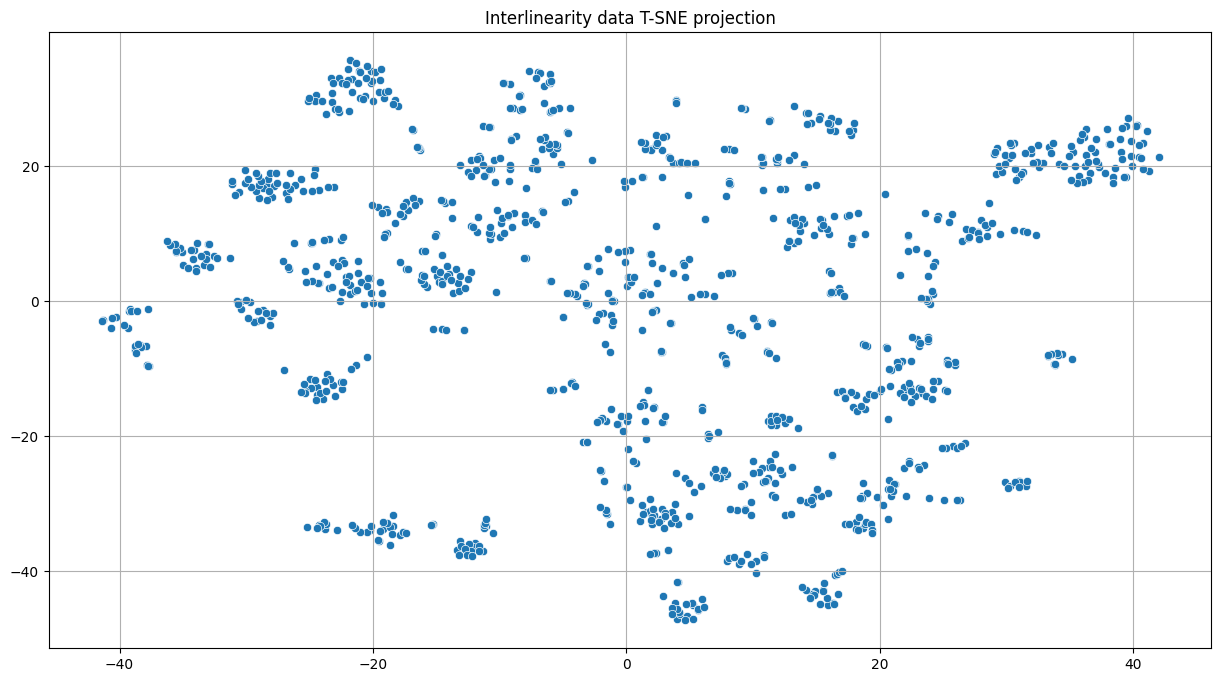

In [48]:
def show(above = 0,below= 0,left = 0,right= 0):
  plt.figure(figsize=(15,8))
  sns.scatterplot(x=tsne_coords[:,0], y=tsne_coords[:,1]).set(title="Interlinearity data T-SNE projection")
  plt.grid()

  # specify the location of (left,bottom),width,height
  coordinates = [((right,above),left-right,below-above)]
  rect=mpatches.Rectangle((right,above),left-right,below-above,
                        fill = False,
                        color = "purple",
                        linewidth = 2)
  plt.gca().add_patch(rect)

  plt.show()

show()

In [49]:
def get_rectangle(above = -1000,below= 1000,left = 1000,right= - 1000, samples = -1):
  pt_list = []
  for i, pt in enumerate(tsne_coords):
    if pt[0]>=left and pt[0]<=right and pt[1]>=above and pt[1]<=below: #and label[i] != 1:
      pt_list.append(i)

  if samples > 0:
    if samples > len(pt_list):
      return pt_list
    else:
      pt_list = random.sample(pt_list, samples)

  return pt_list

There are 82 images in selected area


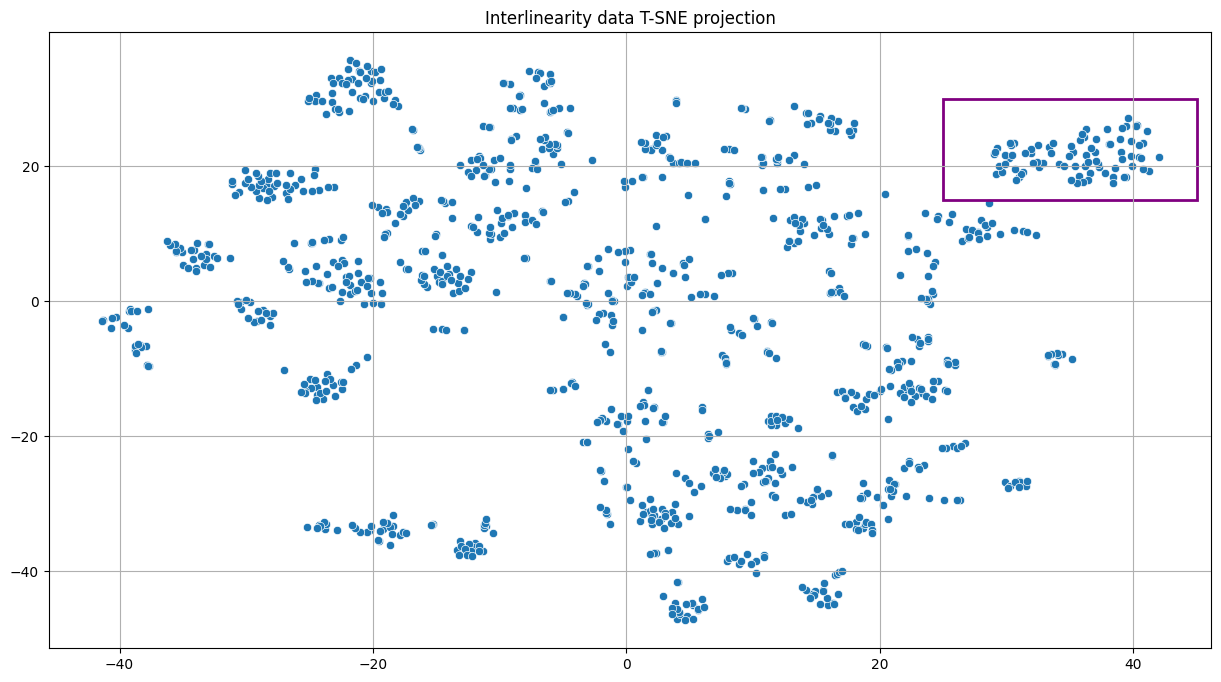

In [52]:
# ***************************** Set rectangle boundaries *************************************** #
right = 45
left = 25
above = 15
below = 30
pt_list = get_rectangle(above=above, below=below, left=left, right=right)
print(f"There are {len(pt_list)} images in selected area")
show(above=above, below=below, left=left, right=right)
# *********************************************************************************************** #

# Once the rectangle fits your needs
## Run the cells below to save results in a folder in Sinai/Groups
* the folder name is formatted as follows: *R:{right}_L:{left}_A:{above}_B:{below}* to indicate rectangle boundaries in case reproduction is needed
<br>
* In each folder will be a *labels.csv* file with image name, model prediction, and true label.
<br>
* Copying the images may take ~minute per 100 images

In [53]:
pt_list = get_rectangle(above=above, below=below, left=left, right=right)

## Save Results to A Folder in TSNE_Groups
* the folder name is formatted as follows: *R:{right}_L:{left}_A:{above}_B:{below}* to indicate rectangle boundaries in case reproduction is needed
<br>
* In each folder will be a *labels.csv* file with image name, model prediction, and true label.
<br>
* Copying the images may take ~minute per 100 images

In [55]:
new_dir = 'TSNE_Groups'
pathlib.Path(new_dir).mkdir(parents=True, exist_ok=True)
new_dir = f'{new_dir}/R:{right}_L:{left}_A:{above}_B:{below}_len{len(pt_list)}'
pathlib.Path(new_dir).mkdir(parents=True, exist_ok=True)

for p in pt_list:

  source_path = tsne_coords_df['file_paths'][p]

  # acquire image folder and page number, i.e: EAP329-2-18/0002.jpg will become EAP329-2-18_SEP_0002.jpg
  image_name = '_SEP_'.join(source_path.split('/')[-2:])
  destination_path = os.path.join(new_dir, image_name)

  shutil.copy(source_path, destination_path)
